In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import gc
from pathlib import Path

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

import lime
import lime.lime_image
import shap

np.random.seed(42)
tf.random.set_seed(42)

# Define constants
DATA_DIR = "/kaggle/input/brain-tumor-mri-dataset"
TRAIN_DIR = os.path.join(DATA_DIR, "Training")
TEST_DIR = os.path.join(DATA_DIR, "Testing")
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
CLASSES = sorted([item.name for item in Path(TRAIN_DIR).iterdir() if item.is_dir()])
NUM_CLASSES = len(CLASSES)
print(f"Classes found: {CLASSES}")

Classes found: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [3]:
# Set up ImageDataGenerator for training and testing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [4]:
# Convert generators to tf.data.Dataset
def gen_to_dataset(generator):
    output_signature = (
        tf.TensorSpec(shape=(None, IMG_SIZE[0], IMG_SIZE[1], 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, NUM_CLASSES), dtype=tf.float32)
    )
    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_signature=output_signature
    )
    return dataset

# Create datasets and apply repeat
train_dataset = gen_to_dataset(train_generator).repeat()
test_dataset = gen_to_dataset(test_generator).repeat()

# Get labels for evaluation
y_train_encoded = train_generator.classes
y_test_encoded = test_generator.classes

# Check class distribution
class_counts = pd.Series(train_generator.classes).value_counts()
print(class_counts)

print(f"Found {train_generator.samples} training images belonging to {NUM_CLASSES} classes.")
print(f"Found {test_generator.samples} testing images belonging to {NUM_CLASSES} classes.")

2    1595
3    1457
1    1339
0    1321
Name: count, dtype: int64
Found 5712 training images belonging to 4 classes.
Found 1311 testing images belonging to 4 classes.


In [12]:
# Define the model architecture
def create_model(input_shape=(224, 224, 3), num_classes=NUM_CLASSES):
    inputs = Input(shape=input_shape)
    
    # Convolution Block 1
    x = Conv2D(32, (3, 3), padding='same', kernel_initializer="lecun_uniform", activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Convolution Block 2
    x = Conv2D(64, (3, 3), padding='same', kernel_initializer="lecun_uniform", activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Convolution Block 3
    x = Conv2D(128, (3, 3), padding='same', kernel_initializer="lecun_uniform", activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Convolution Block 4
    x = Conv2D(256, (3, 3), padding='same', kernel_initializer="lecun_uniform", activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Convolution Block 5
    x = Conv2D(512, (3, 3), padding='same', kernel_initializer="lecun_uniform", activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Dropout layer
    x = Dropout(0.5)(x)
    
    # Flatten
    x = Flatten()(x)
    
    # Dense Block
    x = Dense(512, kernel_initializer=LecunUniformV2(), activation='relu')(x)
    
    # Output layer (Softmax)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Instantiate the model
model = create_model(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=NUM_CLASSES)

In [13]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 14, 14, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,416,196 (54.99 MB)

 Trainable params: 14,416,196 (54.99 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Calculate steps per epoch
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = test_generator.samples // BATCH_SIZE

# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=validation_steps,
    epochs=20,
    verbose=1
)

Epoch 1/20


I0000 00:00:1746486008.439854     105 service.cc:148] XLA service 0x78a63000efe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746486008.440889     105 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746486008.440914     105 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746486008.918023     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/178 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.2344 - loss: 1.4140 

I0000 00:00:1746486016.385140     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


178/178 ━━━━━━━━━━━━━━━━━━━━ 127s 650ms/step - accuracy: 0.4786 - loss: 1.0972 - val_accuracy: 0.6695 - val_loss: 0.7903
Epoch 2/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 86s 461ms/step - accuracy: 0.7261 - loss: 0.6808 - val_accuracy: 0.7021 - val_loss: 0.8480
Epoch 3/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 79s 443ms/step - accuracy: 0.7499 - loss: 0.6147 - val_accuracy: 0.7623 - val_loss: 0.5750
Epoch 4/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 77s 434ms/step - accuracy: 0.7836 - loss: 0.5399 - val_accuracy: 0.7240 - val_loss: 0.7385
Epoch 5/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 77s 436ms/step - accuracy: 0.8123 - loss: 0.4741 - val_accuracy: 0.7654 - val_loss: 0.6081
Epoch 6/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 75s 425ms/step - accuracy: 0.8202 - loss: 0.4468 - val_accuracy: 0.8030 - val_loss: 0.4833
Epoch 7/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 79s 446ms/step - accuracy: 0.8437 - loss: 0.4078 - val_accuracy: 0.8061 - val_loss: 0.4785
Epoch 8/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 79s 445ms/step - accuracy: 0.8590 - loss: 0.3841 - va

In [15]:
# Evaluate the model
test_dataset_eval = gen_to_dataset(test_generator).take(validation_steps)
test_loss, test_accuracy = model.evaluate(test_dataset_eval)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate predictions
test_generator.reset()
y_pred = model.predict(test_generator, steps=validation_steps)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes[:len(y_pred_classes)]

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=CLASSES))

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.9596 - loss: 0.1115
Test Loss: 0.2556
Test Accuracy: 0.9038


Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step

Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.80      0.88       300
  meningioma       0.85      0.81      0.83       306
     notumor       0.92      1.00      0.96       405
   pituitary       0.88      0.99      0.93       269

    accuracy                           0.90      1280
   macro avg       0.90      0.90      0.90      1280
weighted avg       0.91      0.90      0.90      1280



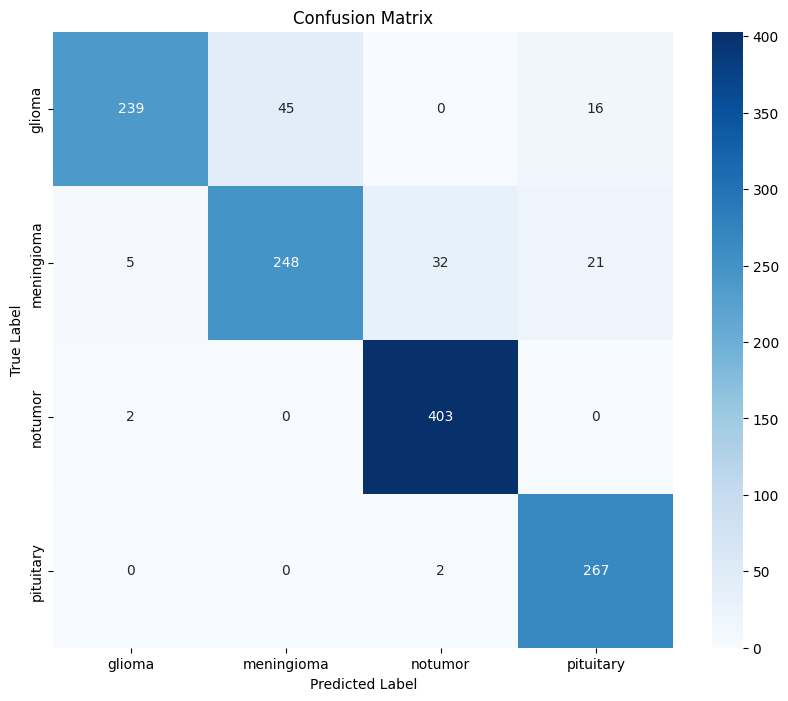

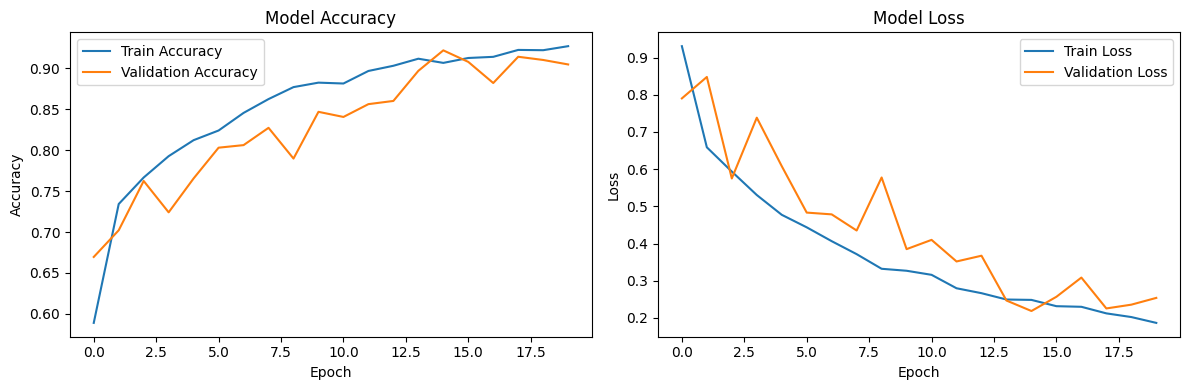

In [16]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step
Predicted class: glioma


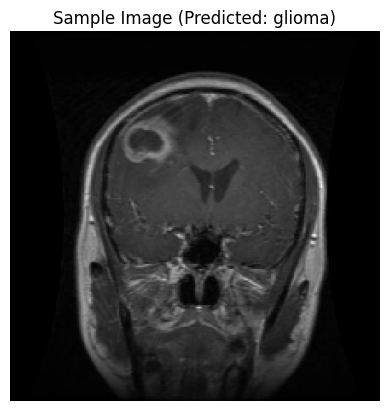

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
import cv2
import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Function to load and preprocess an image
def load_and_preprocess_image(img_path, target_size=IMG_SIZE):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Rescale as done in test_datagen
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array, img

# Select a sample image from the test set
test_dir = TEST_DIR
sample_class = CLASSES[0]  # Choose the first class (e.g., 'glioma')
sample_img_path = os.path.join(test_dir, sample_class, os.listdir(os.path.join(test_dir, sample_class))[0])
sample_img_array, sample_img = load_and_preprocess_image(sample_img_path)

# Predict the class of the sample image
pred = model.predict(sample_img_array)
pred_class = CLASSES[np.argmax(pred[0])]
print(f"Predicted class: {pred_class}")

# Display the sample image
plt.imshow(sample_img)
plt.title(f"Sample Image (Predicted: {pred_class})")
plt.axis('off')
plt.show()

Last convolutional layer: conv2d_17


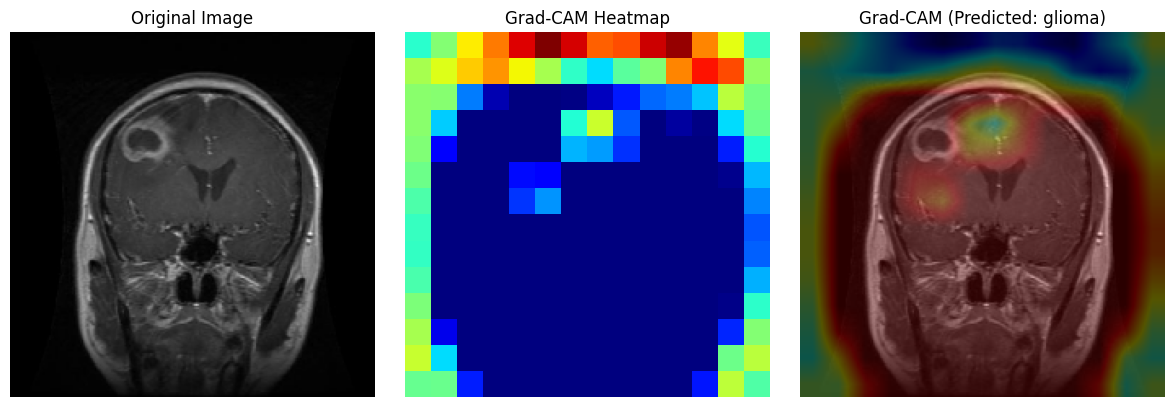

In [18]:
def get_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations of the last conv layer and the output predictions
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # Compute gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]
    
    # Get the gradients of the loss w.r.t. the conv layer output
    grads = tape.gradient(loss, conv_outputs)
    
    # Pool the gradients over the spatial dimensions
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Multiply each channel by its importance (pooled gradients)
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Get the name of the last convolutional layer
last_conv_layer_name = [layer.name for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)][-1]
print(f"Last convolutional layer: {last_conv_layer_name}")

# Generate Grad-CAM heatmap
heatmap = get_gradcam_heatmap(model, sample_img_array, last_conv_layer_name)

# Superimpose the heatmap on the original image
def superimpose_heatmap(heatmap, img, alpha=0.4):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img
    return superimposed_img / superimposed_img.max()

# Convert sample_img to array for superimposing
img_array = img_to_array(sample_img)
superimposed_img = superimpose_heatmap(heatmap, img_array)

# Display the results
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(sample_img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(heatmap, cmap='jet')
plt.title("Grad-CAM Heatmap")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(superimposed_img)
plt.title(f"Grad-CAM (Predicted: {pred_class})")
plt.axis('off')

plt.tight_layout()
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━

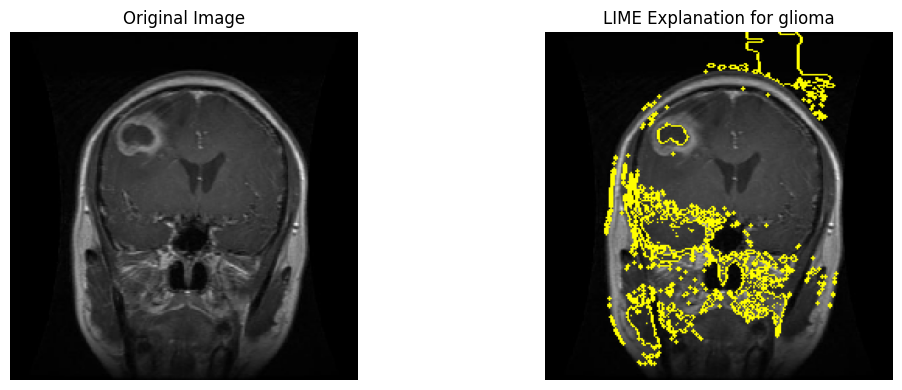

In [24]:
# Define a predict function for LIME (expects images in [0, 255] range)
def lime_predict_fn(images):
    images = images / 255.0  # Rescale to [0, 1]
    return model.predict(images)

# Initialize LIME image explainer
explainer = lime_image.LimeImageExplainer()

# Explain the sample image
explanation = explainer.explain_instance(
    img_to_array(sample_img),
    lime_predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

# Get the explanation for the predicted class
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=True
)

# Plot the LIME explanation
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(sample_img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(img_to_array(sample_img) / 255.0, mask))
plt.title(f"LIME Explanation for {pred_class}")
plt.axis('off')

plt.tight_layout()
plt.show()